In [25]:
import torch
import torch.nn as nn
import gym

from seagul.nn import CategoricalMLP, MLP, DummyNet, fit_model, LinearNet

# TODO maybe import algos into rl __init__
from seagul.rl.algos import ppo_switch
from seagul.rl.algos import ppo

from tqdm import trange
from numpy import pi
import numpy as np

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)

policy = MLP(input_size=6, output_size=1, layer_size=24, num_layers=3, activation=nn.ReLU)
value_fn = MLP(input_size=6, output_size=1, layer_size=24, num_layers=3, activation=nn.ReLU)

#policy = LinearNet(17,6)
#value_fn = LinearNet(17,1)
gate_fn = CategoricalMLP(input_size=6, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)

In [23]:
# Generate data for the supervised learning task
from numpy import arctan2, pi
env = gym.make('su_acrobot-v0')
obs = env.reset()
num_points = int(2e4)

X = torch.zeros(num_points, 6)  
Y = torch.zeros(num_points,1)
y_list.append

for i in trange(num_points):
        
        obs = env.observation_space.sample()
        state = np.array([arctan2(obs[0],obs[1]), arctan2(obs[2], obs[3]), obs[4], obs[5]])
        X[i] = torch.as_tensor(obs)
       
        if((140 * pi/180 < state[0] < 220 * pi/180) and ((-40*pi/180 < state[1] < 40 * pi/180))):
            Y[i] = 1
        else:
            Y[i] = 0
            

100%|██████████| 20000/20000 [00:01<00:00, 12561.33it/s]


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


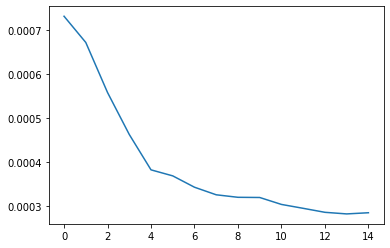

In [26]:
# fit our gating network to the data we generated above

hist = fit_model(gate_fn,X,Y,15)
plt.plot(hist)

In [27]:
# evauluate how well our classifier is doing now

env = gym.make('su_acrobot-v0')
num_points = int(2e4)

pred_Y = torch.zeros(num_points,1)
pred_X = np.zeros((num_points,1))
up_wrong = 0; up_right = 0; down_wrong = 0; down_right = 0;
y_list = []

for i in trange(num_points):
        
        obs = env.observation_space.sample()
        state = np.array([arctan2(obs[0],obs[1]), arctan2(obs[2], obs[3]), obs[4], obs[5]])

        y = gate_fn(torch.as_tensor(obs,dtype=torch.float64))
        y_list.append(y)
        
        if((160 * pi/180 < state[0] < 200 * pi/180) and ((-20*pi/180 < state[1] < 20 * pi/180))):
            if y < .5:
                #print("wrong!" , c)
                up_wrong +=1
            else:
                up_right +=1
        else:
            if y > .5:
                #print("wrong again!" , c)
                down_wrong +=1
            else:
                down_right +=1
       
print("balancing controller misclassified: " , up_wrong)
print("balancing controller corectly classified: " , up_right)
print("balancing controller accuracy: " , up_right/(up_right+up_wrong))

     
print("swingup controller misclassified: " , down_wrong)
print("swingup controller corectly classified: " , down_right)
print("balancing controller accuracy: " , down_right/(down_right+down_wrong))

100%|██████████| 20000/20000 [00:04<00:00, 4325.81it/s]

balancing controller misclassified:  10
balancing controller corectly classified:  86
balancing controller accuracy:  0.8958333333333334
swingup controller misclassified:  246
swingup controller corectly classified:  19658
balancing controller accuracy:  0.9876406752411575


100%|██████████| 100/100 [05:11<00:00,  3.28s/it]


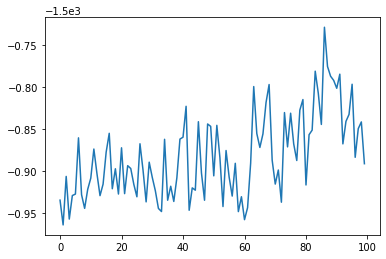

In [2]:
t_policy, t_val, rewards, var_dict = ppo('su_cartpole-v0', 100, policy, value_fn, action_var = .4, p_epochs= 5, v_epochs=15)
#t_policy, t_val, t_gate, rewards, var_dict = ppo_switch(
#    "su_cartpole_push-v0", 500, policy, value_fn, gate_fn, epoch_batch_size=50, reward_stop=1400
#)

plt.plot(rewards)

In [28]:
torch.save(gate_fn, "gate_fn_ac")

In [ ]:
save_path = "./data/push_baselines/push_baseline1"
#model, env = load_model(save_path) # This is loading the trained model for analysis
t_data = pd.read_csv(save_path + '/progress.csv' ) # This is data about the training

In [ ]:
plt.plot(var_dict['action_list'])

In [ ]:
plt.plot(var_dict['path_list'])

In [ ]:
plt.plot(np.array(var_dict['state_tensor'])[:,2])
np.array(var_dict['state_tensor'])

In [ ]:
var_dict['action_tensor']

In [16]:
torch.save(gate_fn, "gate_fn")

Signature:
torch.save(
    ['obj', 'f', "pickle_module=<module 'pickle' from '/home/sgillen/miniconda3/envs/baselines/lib/python3.6/pickle.py'>", 'pickle_protocol=2'],
)
Source:   
def save(obj, f, pickle_module=pickle, pickle_protocol=DEFAULT_PROTOCOL):
    """Saves an object to a disk file.

    See also: :ref:`recommend-saving-models`

    Args:
        obj: saved object
        f: a file-like object (has to implement write and flush) or a string
           containing a file name
        pickle_module: module used for pickling metadata and objects
        pickle_protocol: can be specified to override the default protocol

    .. warning::
        If you are using Python 2, torch.save does NOT support StringIO.StringIO
        as a valid file-like object. This is because the write method should return
        the number of bytes written; StringIO.write() does not do this.

        Please use something like io.BytesIO instead.

    Example:
        >>> # Save to file
        >>> x = t